<a href="https://colab.research.google.com/github/springboardmentor0327/Text_Summarization_Infosys_Internship_Oct2024/blob/Sameer/LLM_advance_refine_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -qU langchain-google-vertexai
%pip install --upgrade --quiet tiktoken langchain langgraph beautifulsoup4 langchain langchain-google-genai langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 13.5 MB/s eta 0:00:00


In [2]:
from google.colab import userdata
# import getpass
import os

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

# from langchain_google_vertexai import ChatGoogle
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [45]:
from langchain_core.documents import Document

documents = [
    Document(page_content="Apples are red", metadata={"title": "apple_book"}),
    Document(page_content="Blueberries are blue", metadata={"title": "blueberry_book"}),
    Document(page_content="Bananas are yelow", metadata={"title": "banana_book"}),
]

In [5]:
!pip install -qU langgraph

In [12]:
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following: {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Produce a final summary.

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

refine_summary_chain = refine_prompt | llm | StrOutputParser()


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str


# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    summary = await initial_summary_chain.ainvoke(
        state["contents"][0],
        config,
    )
    return {"summary": summary, "index": 1}


# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content},
        config,
    )

    return {"summary": summary, "index": state["index"] + 1}


# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"


graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)
app = graph.compile()

In [46]:
import operator
from typing import List, Literal, TypedDict

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

# Initial summary
summarize_prompt = ChatPromptTemplate(
    [
        ("human", "Write a concise summary of the following (max {max_word_count} words): {context}"),
    ]
)
initial_summary_chain = summarize_prompt | llm | StrOutputParser()

# Refining the summary with new docs
refine_template = """
Produce a final summary (between {min_word_count} and {max_word_count} words).

Existing summary up to this point:
{existing_answer}

New context:
------------
{context}
------------

Given the new context, refine the original summary.
"""
refine_prompt = ChatPromptTemplate([("human", refine_template)])

# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    contents: List[str]
    index: int
    summary: str
    max_word_count: int

# Function to check the word count
def is_within_word_count(summary: str, min_count: int, max_count: int) -> bool:
    word_count = len(summary.split())
    return min_count <= word_count <= max_count

# We define functions for each node, including a node that generates
# the initial summary:
async def generate_initial_summary(state: State, config: RunnableConfig):
    min_word_count = state["max_word_count"] - 10
    summary = await initial_summary_chain.ainvoke(
        {"context": state["contents"][0], "max_word_count": state["max_word_count"]},
        config,
    )

    if not is_within_word_count(summary, min_word_count, state["max_word_count"]):
        raise ValueError("Initial summary does not meet word count requirements.")

    word_count = len(summary.split())
    # print(f"Initial summary word count: {word_count}")  # Print the word count
    return {"summary": summary, "index": 1, "word_count": word_count}

# And a node that refines the summary based on the next document
async def refine_summary(state: State, config: RunnableConfig):
    min_word_count = state["max_word_count"] - 10
    content = state["contents"][state["index"]]
    summary = await refine_summary_chain.ainvoke(
        {"existing_answer": state["summary"], "context": content,
         "min_word_count": min_word_count, "max_word_count": state["max_word_count"]},
        config,
    )

    if not is_within_word_count(summary, min_word_count, state["max_word_count"]):
        raise ValueError("Refined summary does not meet word count requirements.")

    word_count = len(summary.split())
    print(f"Refined summary word count: {word_count}")  # Print the word count
    return {"summary": summary, "index": state["index"] + 1, "word_count": word_count}

# Here we implement logic to either exit the application or refine
# the summary.
def should_refine(state: State) -> Literal["refine_summary", END]:
    if state["index"] >= len(state["contents"]):
        return END
    else:
        return "refine_summary"

# Define the state graph
graph = StateGraph(State)
graph.add_node("generate_initial_summary", generate_initial_summary)
graph.add_node("refine_summary", refine_summary)

graph.add_edge(START, "generate_initial_summary")
graph.add_conditional_edges("generate_initial_summary", should_refine)
graph.add_conditional_edges("refine_summary", should_refine)

# Compile the graph into an application
app = graph.compile()

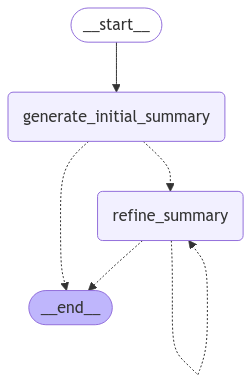

In [47]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [50]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in documents],"max_word_count":10},
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)

Apples: red.

Refined summary word count: 6
Apples are red; blueberries are blue.

Refined summary word count: 10
Apples are red, blueberries are blue, and bananas are yellow.

